# Тестирование работы графовой нейронной сети

In [21]:
import sys
import os
current_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(51)
import warnings
warnings.filterwarnings("ignore")

## Анализ и подготовка данных

In [3]:
from graph_nn.data_preparation import prepare_dataset, prepare_data

In [4]:
x_train,x_test=prepare_dataset("../data/dichalcogenides_public")

In [5]:
print(x_train['structures'].iloc[0]) #Данные об отдельной молекуле

Full Formula (Mo63 W1 Se1 S126)
Reduced Formula: Mo63WSeS126
abc   :  25.522526  25.522526  14.879004
angles:  90.000000  90.000000 120.000000
pbc   :       True       True       True
Sites (191)
  #  SP           a         b         c
---  ----  --------  --------  --------
  0  Mo    0.041667  0.083333  0.25
  1  Mo    0.041667  0.333333  0.25
  2  Mo    0.041667  0.458333  0.25
  3  Mo    0.041667  0.583333  0.25
  4  Mo    0.041667  0.708333  0.25
  5  Mo    0.041667  0.833333  0.25
  6  Mo    0.041667  0.958333  0.25
  7  Mo    0.166667  0.083333  0.25
  8  Mo    0.166667  0.208333  0.25
  9  Mo    0.166667  0.333333  0.25
 10  Mo    0.166667  0.458333  0.25
 11  Mo    0.166667  0.583333  0.25
 12  Mo    0.166667  0.708333  0.25
 13  Mo    0.166667  0.833333  0.25
 14  Mo    0.166667  0.958333  0.25
 15  Mo    0.291667  0.083333  0.25
 16  Mo    0.291667  0.208333  0.25
 17  Mo    0.291667  0.333333  0.25
 18  Mo    0.291667  0.458333  0.25
 19  Mo    0.291667  0.583333  0.25
 20 

In [6]:
A=np.array([])
B=np.array([])
for i in range(x_train.shape[0]):
    A=np.append(A,np.array(x_train['structures'].iloc[i].species))#Массив со всеми атомами
    B=np.append(B,len(x_train['structures'].iloc[i].species))#Массив с количествами атомов внутри молекулы

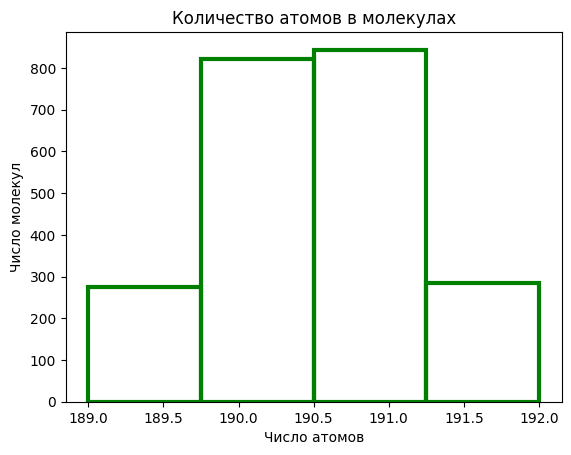

In [7]:
style = {'facecolor': 'none', 'edgecolor': 'g', 'linewidth': 3}
plt.hist(B, color='g', bins=4, **style)
plt.title('Количество атомов в молекулаx')
plt.xlabel('Число атомов')
plt.ylabel('Число молекул')
plt.show()

Разброс среди размеров молекул небольшой, поэтому датасет можно будет привести к максимальной размерности, а молекулы меньшего размера будут дополнены нулями. Уникальных атомов тоже немного, поэтому их можно использовать, как признаки.

После обучения модели на различных признаках, которые можно было получить из данных о молекуле, было принято решение оставить 5 признаков: 4 бинарных - атом в молекуле, и 1 непрервыный - средняя длина ребра атома до других атомов молекулы

In [8]:
data, matrices, real_shapes=prepare_data(x_train)#Получение тренировочного датасета
data_test, matrices_test, real_shapes_test=prepare_data(x_test)#Получение тестового датасета

In [9]:
y_train=x_train['targets'].values.reshape(-1,1)#Получение тренировочных таргетов
y_test=x_test['targets'].values.reshape(-1,1)#Получение тестовых таргетов

## Обучение нейронной сети

In [10]:
from graph_nn.GNN import GNN

In [11]:
gnn=GNN((5, 512, 256,128,64))

In [12]:
epoch_losses=gnn.train(data, matrices, real_shapes, y_train, data_test,matrices_test, real_shapes_test,y_test,epochs=45, exp_rate=0.95, batch_size=1, lr=0.001)

----------------------------------------------------------------------
Epoch: 1
mse: 0.06647251643173453
mae: 0.22227192507556315
R^2: 0.739824753710705
eWt: 0.05525606469002695
----------------------------------------------------------------------
Epoch: 2
mse: 0.051050692584079516
mae: 0.17283491574836723
R^2: 0.8001861937942073
eWt: 0.12398921832884097
----------------------------------------------------------------------
Epoch: 3
mse: 0.025068962334087248
mae: 0.1042480697286526
R^2: 0.9018793961834368
eWt: 0.1280323450134771
----------------------------------------------------------------------
Epoch: 4
mse: 0.02032228873980145
mae: 0.08532411981638033
R^2: 0.9204580063781701
eWt: 0.11455525606469003
----------------------------------------------------------------------
Epoch: 5
mse: 0.01633358204894556
mae: 0.06436483346338802
R^2: 0.9360699133944321
eWt: 0.3045822102425876
----------------------------------------------------------------------
Epoch: 6
mse: 0.015483379453609745
m

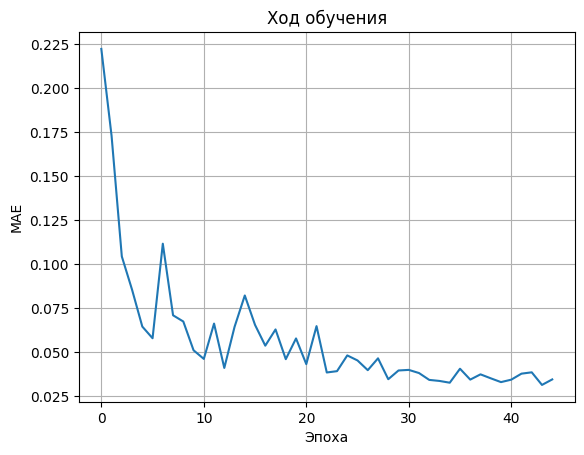

In [13]:
plt.plot(epoch_losses)
plt.title('Ход обучения')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.grid()
plt.show()

In [14]:
y_pred=gnn.predict(data_test,matrices_test, real_shapes_test)

In [16]:
from utils.metrics import mse, mae, R_square, eWt

Основной метрикой в рамках решения данной задачи была максимизации метрики eWt - доли предсказаний, попавших в окрестность 0.02

In [17]:
print('mse:',mse(y_pred,y_test))
print('mae:',mae(y_pred,y_test))
print('R^2:',R_square(y_pred,y_test))
print('eWt:',eWt(y_pred,y_test))

mse: 0.009518712024644174
mae: 0.03431883687075433
R^2: 0.9627435009488169
eWt: 0.6455525606469003


In [18]:
ewts=[]
for i in range(1,21):
    ewts.append(eWt(y_pred,y_test,t=0.01*i))

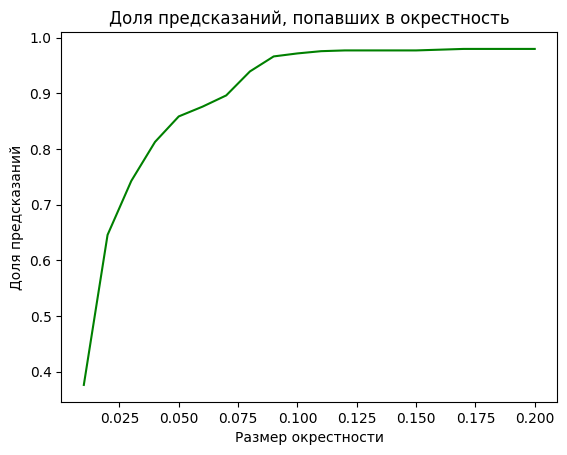

In [19]:
plt.plot([i/100 for i in range (1,21)],ewts, c='g')
plt.title('Доля предсказаний, попавших в окрестность')
plt.xlabel('Размер окрестности')
plt.ylabel('Доля предсказаний')
plt.show()